In [1]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import sklearn.metrics
import torch.nn as nn
import torch.nn.functional as F


# Hyperparameters

In [2]:
epochs = 15
learningRate = 0.01
batchSize = 100
inputs = 784
outputs = 10
noOfNodesL1 = 500
noOfNodesL2 = 250
noOfNodesL3 = 100
activations = ['sigmoid' , 'reLu' , 'tanh']
alpha = 1e-5


# Useful Functions

In [3]:
def loadDataSet(): # Loading DataSet
  """
  60k Train Data in batches of "batchSize"
  10k Test Data
  """
  trainData = torchvision.datasets.MNIST('./data' , train=True, transform= np.asarray, download=True)
  testData = torchvision.datasets.MNIST('./data' , train=False, transform= np.asarray , download = True)
  trainDataLoader = DataLoader(trainData , batch_size = batchSize , shuffle = True)
  return trainDataLoader , testData , trainData


In [4]:
def loadDataSetPy(): # Loading DataSet for pyTorch
  """
  60k Train Data in batches of "batchSize"
  10k Test Data
  """
  Transform = transforms.ToTensor()
  trainData = torchvision.datasets.MNIST('./data' , train=True, transform= Transform, download=True)
  testData = torchvision.datasets.MNIST('./data' , train=False, transform= Transform , download = True)
  trainDataLoader = DataLoader(trainData , batch_size = batchSize , shuffle = True)
  return trainDataLoader , testData , trainData


In [5]:
def creatingOutputVector(trainLabels):
  """
  trainLabels - Labels of Input Train Data of a Partiular Batch. (Size: batchSize X 1)
  yReal - True Output. Size: (batchSize X 10)
  """
  batchSize = len(trainLabels)
  yReal = np.zeros([batchSize , 10]) # BatchSize X 10 Matrix
  for j in range(batchSize):
    yReal[j][trainLabels[j]] = 1
  return yReal


In [6]:
def sigmoid(x): 
  """
  Returns the Sigmoid of x
  """
  s = 1/(1+np.exp(-x))
  return s

In [7]:
def tanh(x):
  """
  Returns element wise tanh of x
  """
  th = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
  return th
  

In [8]:
def relu(x):
  relu = np.maximum(0,x)
  return relu

In [9]:
def derivativeOfTanh(x):
  doth = 1 - tanh(x)*tanh(x)
  return doth

In [10]:
def derivativeOfRelu(x):
  dorel = x >= 0
  return dorel

In [11]:
def softMax(y): 
  """
  y - Output, before applying softmax. Expected Size: (batchSize X 10)
  sm - softMax. SoftMax is applied along each row of y

  """
  denom = np.sum(np.exp(y) , axis = 1 , keepdims = True)
  #print(denom.shape)
  sm = np.exp(y)/denom
  return sm

# MLP

In [12]:
def initializingParameters(): 
  """
  Return Values 
  w1: Weight for Layer 1. Size: (no.of Inputs X no.of Nodes in L1)
  w2: Weight for Layer 2. Size: (no.of Nodes in L1 X no.of Nodes in L2)
  w3: Weight for Layer 3. Size: (no.of Nodes in L2 X no.of Nodes in L3)
  w4: Weight for Layer 4. Size: (no.of Nodes in L3 X no.of Nodes in L4)

  
  b1: Bias for Layer 1. Size: (1 X no.of Nodes in L1)
  b2: Bias for Layer 2. Size: (1 X no.of Nodes in L2)
  b3: Bias for Layer 3. Size: (1 X no.of Nodes in L3)
  b4: Bias for Layer 4. Size: (1 X no.of Outputs)


  """
  w1 = 2*np.sqrt(6/(inputs+noOfNodesL1))*np.random.rand(inputs,noOfNodesL1) - np.sqrt(6/(inputs+noOfNodesL1))
  w2 = 2*np.sqrt(6/(noOfNodesL1+noOfNodesL2))*np.random.rand(noOfNodesL1,noOfNodesL2) - np.sqrt(6/(noOfNodesL1+noOfNodesL2))
  w3 = 2*np.sqrt(6/(noOfNodesL2+noOfNodesL3))*np.random.rand(noOfNodesL2,noOfNodesL3) - np.sqrt(6/(noOfNodesL2+noOfNodesL3))
  w4 = 2*np.sqrt(6/(noOfNodesL3+outputs))*np.random.rand(noOfNodesL3,outputs) - np.sqrt(6/(noOfNodesL3+outputs))
  b1 = np.zeros([1,noOfNodesL1])
  b2 = np.zeros([1,noOfNodesL2] )
  b3  = np.zeros([1,noOfNodesL3 ])
  b4 = np.zeros([1,outputs])
  return w1 , b1 , w2, b2 , w3 , b3 , w4 , b4

In [13]:
def predict(Data, w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 , activation):
  
  temp = Data.data.numpy()
  X = (1./255)*(temp.reshape(temp.shape[0] , -1))
  yReal = creatingOutputVector(Data.targets.numpy().astype(int))
  
  ## Sigmoid
  if activation == 'sigmoid':
    # Layer 1
    z1 = np.dot(X , w1) + b1  # size: (batchSize x no. of nodes in L1)
    a1 = sigmoid(z1)

    # Layer 2
    z2 = np.dot(a1 , w2) + b2 # size: (batchSize x no. of nodes in L2)
    a2 = sigmoid(z2)

    # Layer 3
    z3 = np.dot(a2 , w3) + b3 # size: (batchSize x no. of nodes in L3)
    a3 = sigmoid(z3)

    # Layer 4
    z4 = np.dot(a3 , w4) + b4 # size: (batchSize x no. of nodes in Outputs)
    yPred = softMax(z4)

  ## Tanh Activation
  if activation == 'tanh':
    # Layer 1
    z1 = np.dot(X , w1) + b1  # size: (batchSize x no. of nodes in L1)
    a1 = tanh(z1)

    # Layer 2
    z2 = np.dot(a1 , w2) + b2 # size: (batchSize x no. of nodes in L2)
    a2 = tanh(z2)

    # Layer 3
    z3 = np.dot(a2 , w3) + b3 # size: (batchSize x no. of nodes in L3)
    a3 = tanh(z3)

    # Layer 4
    z4 = np.dot(a3 , w4) + b4 # size: (batchSize x no. of nodes in Outputs)
    yPred = softMax(z4)

  if activation == 'reLu':
    # Layer 1
    z1 = np.dot(X , w1) + b1  # size: (batchSize x no. of nodes in L1)
    a1 = relu(z1)

    # Layer 2
    z2 = np.dot(a1 , w2) + b2 # size: (batchSize x no. of nodes in L2)
    a2 = relu(z2)

    # Layer 3
    z3 = np.dot(a2 , w3) + b3 # size: (batchSize x no. of nodes in L3)
    a3 = relu(z3)

    # Layer 4
    z4 = np.dot(a3 , w4) + b4 # size: (batchSize x no. of nodes in Outputs)
    yPred = softMax(z4)

  predictedNumber = np.argmax(yPred , axis = 1)
  realNumber = np.argmax(yReal ,axis = 1)
  noOfRightPrediction = np.sum(predictedNumber == realNumber)
  totalPrediction = yPred.shape[0]
  accuracy = noOfRightPrediction/totalPrediction
  confusionMatrix = sklearn.metrics.confusion_matrix(realNumber , predictedNumber)



  return accuracy , confusionMatrix

In [49]:
def optimisation(trainData, w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 , learningRate , activation , printCost , epochs , testEpochs):
  """
  Input Arguments
  trainData     - Train Data in Mini Batches
  learningRate  - For Gradient Descent

  Return Values
  w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 - Optimized Parameters

  """
  totalCost = []
  for j in range(epochs):
    i = 1
    if printCost: 
      print('Epoch {}'.format(j))
    for miniBatch in trainData:
      
      ### INITIALIZING ###

      trainFeatures , trainLabels = miniBatch
      X = (1./255)*(trainFeatures.reshape(batchSize , -1).numpy())
      yReal = creatingOutputVector(trainLabels)

      ### COMPUTING GRADS AND COST ###
      
      grad , cost =  propagate(X , yReal , w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 , activation)
      if i%100 == 0 and printCost == True:
        print ("Cost after MiniBatch %i: %f" %(i, cost))
      if i%100 == 0:
        totalCost.append(cost)
      i += 1
      
      ### UPDATING THE PARAMETERS ###

      w1 = w1 - learningRate*grad['dw1']
      w2 = w2 - learningRate*grad['dw2']
      w3 = w3 - learningRate*grad['dw3']
      w4 = w4 - learningRate*grad['dw4']
      b1 = b1 - learningRate*grad['db1']
      b2 = b2 - learningRate*grad['db2']
      b3 = b3 - learningRate*grad['db3']
      b4 = b4 - learningRate*grad['db4']
    if testEpochs:
      plt.plot(totalCost)
      plt.xlabel('Mini Batches')
      plt.ylabel('Cost')
      plt.show()
      testAccuracy , confusionMatrix = predict(testData , w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 , 'reLu')
      accuracy.append(testAccuracy*100)
      print('For No. Of Epochs = ', j+1 , 'Accuracy = ', testAccuracy*100)

    
      
  return w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 , totalCost




In [16]:
def propagate(X , yReal , w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 , activation):
  """
  Input Arguments

  X     -   Input. Size: (batchSize x no. of inputs)
  yReal -   Real Output. Size: (batchSize x 10) 
  w1    -   Weight for Layer 1. Size: (no.of Inputs X no.of Nodes in L1)
  w2    -   Weight for Layer 2. Size: (no.of Nodes in L1 X no.of Nodes in L2)
  w3    -   Weight for Layer 3. Size: (no.of Nodes in L2 X no.of Nodes in L3)
  w4    -   Weight for Layer 4. Size: (no.of Nodes in L3 X no.of Nodes in L4)
  b1    -   Bias for Layer 1. Size: (1 X no.of Nodes in L1)
  b2    -   Bias for Layer 2. Size: (1 X no.of Nodes in L2)
  b3    -   Bias for Layer 3. Size: (1 X no.of Nodes in L3)
  b4    -   Bias for Layer 4. Size: (1 X no.of Outputs)

  Return Values

  grad  -   Dictionary containg gradients of w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4
  cost  -   Forward Propagated Cost for the particular set of Parameters 
  """
  ### FORWARD PROPAGATION ###
  
  ## Sigmoid
  if activation == 'sigmoid':
    # Layer 1
    z1 = np.dot(X , w1) + b1  # size: (batchSize x no. of nodes in L1)
    a1 = sigmoid(z1)

    # Layer 2
    z2 = np.dot(a1 , w2) + b2 # size: (batchSize x no. of nodes in L2)
    a2 = sigmoid(z2)

    # Layer 3
    z3 = np.dot(a2 , w3) + b3 # size: (batchSize x no. of nodes in L3)
    a3 = sigmoid(z3)

    # Layer 4
    z4 = np.dot(a3 , w4) + b4 # size: (batchSize x no. of nodes in Outputs)
    yPred = softMax(z4)

  ## Tanh Activation
  if activation == 'tanh':
    # Layer 1
    z1 = np.dot(X , w1) + b1  # size: (batchSize x no. of nodes in L1)
    a1 = tanh(z1)

    # Layer 2
    z2 = np.dot(a1 , w2) + b2 # size: (batchSize x no. of nodes in L2)
    a2 = tanh(z2)

    # Layer 3
    z3 = np.dot(a2 , w3) + b3 # size: (batchSize x no. of nodes in L3)
    a3 = tanh(z3)

    # Layer 4
    z4 = np.dot(a3 , w4) + b4 # size: (batchSize x no. of nodes in Outputs)
    yPred = softMax(z4)

  if activation == 'reLu':
    # Layer 1
    z1 = np.dot(X , w1) + b1  # size: (batchSize x no. of nodes in L1)
    a1 = relu(z1)

    # Layer 2
    z2 = np.dot(a1 , w2) + b2 # size: (batchSize x no. of nodes in L2)
    a2 = relu(z2)

    # Layer 3
    z3 = np.dot(a2 , w3) + b3 # size: (batchSize x no. of nodes in L3)
    a3 = relu(z3)

    # Layer 4
    z4 = np.dot(a3 , w4) + b4 # size: (batchSize x no. of nodes in Outputs)
    yPred = softMax(z4)



  ### COMPUTING COST ###

  cost = (-1./batchSize)*np.sum(yReal*(np.log2(yPred)))

  ### BACKWARD PROPOGATION ###
  ## Sigmoid
  if activation == 'sigmoid':
    dz4 = -(yReal - yPred)

    dw4 = (1./batchSize)*np.dot(dz4.T , a3) # Grad of w4. Size: (100 X 10)
    db4 = (1./batchSize)*np.sum(dz4 , axis = 0 , keepdims = True) # Grad of b4. Size: (1 X 10)

    da3 = np.dot(w4 , dz4.T)
    dz3 = da3.T*sigmoid(z3)*(1-sigmoid(z3))

    dw3 = (1./batchSize)*np.dot(dz3.T , a2) # Grad of w3. Size: (250 X 100)
    db3 = (1./batchSize)*np.sum(dz3 , axis = 0 , keepdims = True) # Grad of b3. Size: (1 X 100)

    da2 = np.dot(w3,dz3.T)
    dz2 = da2.T*sigmoid(z2)*(1-sigmoid(z2))

    dw2 = 1./batchSize*np.dot(dz2.T , a1) # Grad of w2. Size: (500 X 250)
    db2 = 1./batchSize*np.sum(dz2 , axis = 0 , keepdims = True) # Grad of b2. Size: (1 X 250)

    da1 = np.dot(w2,dz2.T)
    dz1 = da1.T*sigmoid(z1)*(1-sigmoid(z1))
    
    dw1 = 1./batchSize*np.dot(dz1.T , X) # Grad of w1. Size: (784 X 500)
    db1 = 1./batchSize*np.sum(dz1 , axis = 0 , keepdims = True) # Grad of b1. Size: (1 X 500)
  
  if activation == 'tanh':
    dz4 = -(yReal - yPred)

    dw4 = (1./batchSize)*np.dot(dz4.T , a3) # Grad of w4. Size: (100 X 10)
    db4 = (1./batchSize)*np.sum(dz4 , axis = 0 , keepdims = True) # Grad of b4. Size: (1 X 10)

    da3 = np.dot(w4 , dz4.T)
    dz3 = da3.T*derivativeOfTanh(z3)

    dw3 = (1./batchSize)*np.dot(dz3.T , a2) # Grad of w3. Size: (250 X 100)
    db3 = (1./batchSize)*np.sum(dz3 , axis = 0 , keepdims = True) # Grad of b3. Size: (1 X 100)

    da2 = np.dot(w3,dz3.T)
    dz2 = da2.T*derivativeOfTanh(z2)

    dw2 = 1./batchSize*np.dot(dz2.T , a1) # Grad of w2. Size: (500 X 250)
    db2 = 1./batchSize*np.sum(dz2 , axis = 0 , keepdims = True) # Grad of b2. Size: (1 X 250)

    da1 = np.dot(w2,dz2.T)
    dz1 = da1.T*derivativeOfTanh(z1)
    
    dw1 = 1./batchSize*np.dot(dz1.T , X) # Grad of w1. Size: (784 X 500)
    db1 = 1./batchSize*np.sum(dz1 , axis = 0 , keepdims = True) # Grad of b1. Size: (1 X 500)

  if activation == 'reLu':
    dz4 = -(yReal - yPred)

    dw4 = (1./batchSize)*np.dot(dz4.T , a3) # Grad of w4. Size: (100 X 10)
    db4 = (1./batchSize)*np.sum(dz4 , axis = 0 , keepdims = True) # Grad of b4. Size: (1 X 10)

    da3 = np.dot(w4 , dz4.T)
    dz3 = da3.T*derivativeOfRelu(z3)

    dw3 = (1./batchSize)*np.dot(dz3.T , a2) # Grad of w3. Size: (250 X 100)
    db3 = (1./batchSize)*np.sum(dz3 , axis = 0 , keepdims = True) # Grad of b3. Size: (1 X 100)

    da2 = np.dot(w3,dz3.T)
    dz2 = da2.T*derivativeOfRelu(z2)

    dw2 = 1./batchSize*np.dot(dz2.T , a1) # Grad of w2. Size: (500 X 250)
    db2 = 1./batchSize*np.sum(dz2 , axis = 0 , keepdims = True) # Grad of b2. Size: (1 X 250)

    da1 = np.dot(w2,dz2.T)
    dz1 = da1.T*derivativeOfRelu(z1)
    
    dw1 = 1./batchSize*np.dot(dz1.T , X) # Grad of w1. Size: (784 X 500)
    db1 = 1./batchSize*np.sum(dz1 , axis = 0 , keepdims = True) # Grad of b1. Size: (1 X 500)

  grad = {'dz4': dz4 ,'dw4': dw4.T,'db4': db4,
          'dw3': dw3.T,'db3':db3 , 'dw2': dw2.T , 'db2': db2 , 
          'dw1': dw1.T , 'db1': db1}

  return grad , cost

In [40]:
def Model(activation , learningRate , printCost , epochs , testEpochs):
  ## LOADING THE DATA AND INITIALIZING PARAMETERS  ##
  
  trainDataMinB , testData , trainData ,  =  loadDataSet()
  w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 = initializingParameters()

  ## OPTIMIZATING THE PARAMETERS ##

  w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 , totalCost = optimisation(trainDataMinB, w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 , learningRate , activation ,printCost , epochs , testEpochs)
  print()
  plt.plot(totalCost)
  plt.xlabel('Mini Batches')
  plt.ylabel('Cost')
  plt.show()
  
  return w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 , trainData , testData





# Train Loss Plot | Confusion Matrix | Accuracy

**Out of all the Activation, ReLU seems to perform the best with an accuracy close to 97%**


*   Sigmoid - 70%
*   ReLU - 96%
*   tanh - 95%



# 2. Using PyTorch

The best Activation Function turns out to be ReLU. Will be implementing, ReLU using pyTorch functions and Adam Optimizer instead of Gradient Descent


Using sigmoid Activation

UNTRAINED ACCURACY AND CONFUSION MATRIX

Train Accuracy =  9.871666666666666 %
Test Accuracy =  9.8 %
Confusion Matrix on Train Data: 

[[5923    0    0    0    0    0    0    0    0    0]
 [6742    0    0    0    0    0    0    0    0    0]
 [5958    0    0    0    0    0    0    0    0    0]
 [6131    0    0    0    0    0    0    0    0    0]
 [5842    0    0    0    0    0    0    0    0    0]
 [5421    0    0    0    0    0    0    0    0    0]
 [5918    0    0    0    0    0    0    0    0    0]
 [6265    0    0    0    0    0    0    0    0    0]
 [5851    0    0    0    0    0    0    0    0    0]
 [5949    0    0    0    0    0    0    0    0    0]]

Confusion Matrix on Test Data: 

[[ 980    0    0    0    0    0    0    0    0    0]
 [1135    0    0    0    0    0    0    0    0    0]
 [1032    0    0    0    0    0    0    0    0    0]
 [1010    0    0    0    0    0    0    0    0    0]
 [ 982    0    0    0    0    0    0    0    0    0]
 [ 892  

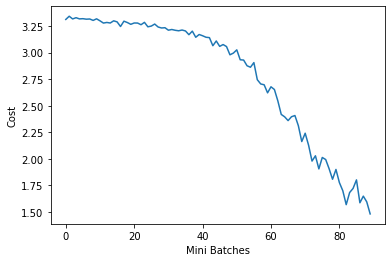


Train Accuracy =  69.48 %
Test Accuracy =  70.11 %
Confusion Matrix on Train Data: 

[[5521    1   25   88   60  104   54   18   41   11]
 [   0 6560   71   22    0   10    2   16   59    2]
 [  84  599 3803  338   91   51  762   55  152   23]
 [  98  213  192 4886   12  247   17  124  319   23]
 [   9   39   42    0 4150    2  284  142   71 1103]
 [1186   98  253 1315   74 1225  112  419  537  202]
 [ 102   62  778   12   84   34 4752    0   93    1]
 [ 121  318   64    6   37   11   24 5288   99  297]
 [ 208  724  482 1037   64  274  123  186 2558  195]
 [  86   85   11   49 1220   62   33 1363   95 2945]]

Confusion Matrix on Test Data: 

[[ 922    0    2   13   10   21    8    1    3    0]
 [   0 1115    8    4    0    0    1    1    6    0]
 [  16  134  625   66   10   12  134    9   25    1]
 [  12   21   30  840    1   39    2   19   42    4]
 [   1    8   12    0  698    0   48   24    4  187]
 [ 195    9   41  245    9  197   21   85   66   24]
 [  29    6   81    1   23    8

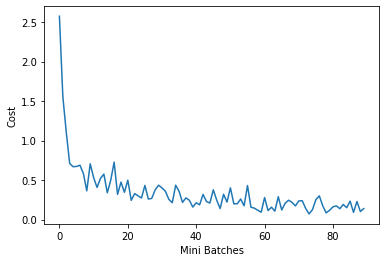


Train Accuracy =  96.96833333333333 %
Test Accuracy =  96.23 %
Confusion Matrix on Train Data: 

[[5811    1    9    5    6   12   32   11   24   12]
 [   1 6635   30   23    8    1    3   14   22    5]
 [  16   24 5736   54   22    5   15   46   35    5]
 [   4    8   43 5943    2   34    5   38   34   20]
 [   5   15   14    0 5667    3   28   10   11   89]
 [  17   10   10  103   14 5174   39    6   33   15]
 [  24    9    9    1   15   21 5827    1   11    0]
 [   5   21   27   14   25    1    1 6124    5   42]
 [  13   45   11   88    9   26   26    8 5600   25]
 [  13   11    2   58   75   14    3   85   24 5664]]

Confusion Matrix on Test Data: 

[[ 964    0    1    1    1    3    5    4    1    0]
 [   0 1120    2    2    0    1    3    2    5    0]
 [   5    1  994    9    4    0    3   10    6    0]
 [   0    0    3  990    0    2    0    9    4    2]
 [   1    0    6    0  951    0    5    3    2   14]
 [   9    1    1   26    3  829   10    0   10    3]
 [   8    3    0   

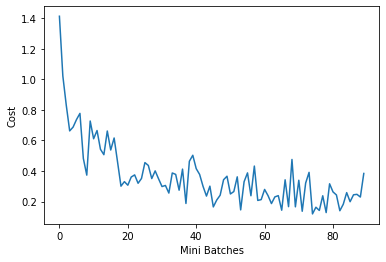


Train Accuracy =  95.40333333333334 %
Test Accuracy =  95.19999999999999 %
Confusion Matrix on Train Data: 

[[5772    1   11    8    8   24   42    6   46    5]
 [   1 6606   31   24    8    8    4   10   40   10]
 [  22   25 5648   49   50   11   37   52   55    9]
 [   6   19   81 5772    4   91   16   40   72   30]
 [   8   21   25    3 5586    1   41   10   22  125]
 [  28   15   20  131   28 5032   60    8   66   33]
 [  27   13   20    2   18   36 5776    0   26    0]
 [  18   28   55   15   45    8    2 6005    7   82]
 [  16   76   31   80   15   56   40   13 5496   28]
 [  26   21    9   65  131   17    1   84   46 5549]]

Confusion Matrix on Test Data: 

[[ 964    0    1    1    0    4    6    1    3    0]
 [   0 1117    2    2    1    1    4    2    6    0]
 [   8    1  975   10    8    1    8    8   12    1]
 [   0    1   10  967    0    8    2   10   11    1]
 [   1    2    5    0  937    0    9    2    4   22]
 [   9    1    0   27    3  814   10    3   19    6]
 [   9 

In [ ]:
trainDataLoader , testData , trainData = loadDataSet()




for activation in activations:
  w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 = initializingParameters()
  print('Using',activation , 'Activation')
  print()
  print('UNTRAINED ACCURACY AND CONFUSION MATRIX')
  print()
  trainAccuracy, confusionMatrixTrain = predict(trainData, w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 , activation)
  print('Train Accuracy = ' , trainAccuracy*100 , '%')


  testAccuracy, confusionMatrixTest = predict(testData, w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 ,activation)
  print('Test Accuracy = ' , testAccuracy*100 , '%')
  print('Confusion Matrix on Train Data: ')
  print()
  print(confusionMatrixTrain)
  print()
  print('Confusion Matrix on Test Data: ')
  print()
  print(confusionMatrixTest)
  print()
  print()
  print('TRAINED ACCURACY AND CONFUSION MATRIX')
  w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 , trainData , testData = Model(activation , learningRate , True , epochs , False) # Training
  print() 
  trainAccuracy, confusionMatrixTrain = predict(trainData, w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 , activation)
  print('Train Accuracy = ' , trainAccuracy*100 , '%')


  testAccuracy, confusionMatrixTest = predict(testData, w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 ,activation)
  print('Test Accuracy = ' , testAccuracy*100 , '%')
  print('Confusion Matrix on Train Data: ')
  print()
  print(confusionMatrixTrain)
  print()
  print('Confusion Matrix on Test Data: ')
  print()
  print(confusionMatrixTest)
  print()
  print()
  print('--------------------------------------------------------------------------------------------------------')





In [17]:
def predictPy(testData , model):
  temp = testData.data 
  X = (1./255)*(temp.reshape(temp.shape[0] , -1))
  yReal = torch.tensor(creatingOutputVector(testData.targets))
  yPred = model(X)
  
  predictedNumber = torch.argmax(yPred , dim = 1)
  realNumber = torch.argmax(yReal ,dim = 1)
  noOfRightPrediction = torch.sum(predictedNumber == realNumber)
  totalPrediction = yPred.shape[0]
  accuracy = noOfRightPrediction/totalPrediction
  confusionMatrix = sklearn.metrics.confusion_matrix(realNumber , predictedNumber)



  return accuracy , confusionMatrix


Epoch 0
Cost after MiniBatch 0: 2.293758
Cost after MiniBatch 100: 0.474076
Cost after MiniBatch 200: 0.217936
Cost after MiniBatch 300: 0.195076
Cost after MiniBatch 400: 0.099387
Cost after MiniBatch 500: 0.092010
Epoch 1
Cost after MiniBatch 0: 0.103145
Cost after MiniBatch 100: 0.230452
Cost after MiniBatch 200: 0.082260
Cost after MiniBatch 300: 0.050182
Cost after MiniBatch 400: 0.126070
Cost after MiniBatch 500: 0.059814
Epoch 2
Cost after MiniBatch 0: 0.037104
Cost after MiniBatch 100: 0.320596
Cost after MiniBatch 200: 0.184337
Cost after MiniBatch 300: 0.355490
Cost after MiniBatch 400: 0.044481
Cost after MiniBatch 500: 0.109789
Epoch 3
Cost after MiniBatch 0: 0.080796
Cost after MiniBatch 100: 0.107820
Cost after MiniBatch 200: 0.114091
Cost after MiniBatch 300: 0.014644
Cost after MiniBatch 400: 0.094080
Cost after MiniBatch 500: 0.038871
Epoch 4
Cost after MiniBatch 0: 0.091511
Cost after MiniBatch 100: 0.032107
Cost after MiniBatch 200: 0.031339
Cost after MiniBatch 300:

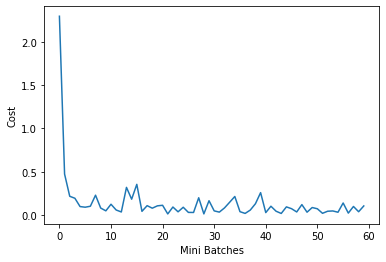

In [19]:
trainDataLoader , testData , trainData = loadDataSetPy()


# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
    def __init__(self, inputs,noOfNodesL1 , noOfNodesL2 , noOfNodesL3, outputs):
        super(NeuralNet, self).__init__()
        self.inputs = inputs
        self.l1 = nn.Linear(inputs, noOfNodesL1) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(noOfNodesL1, noOfNodesL2)
        self.l3 = nn.Linear(noOfNodesL2 , noOfNodesL3)
        self.l4 = nn.Linear(noOfNodesL3 , outputs)
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.l4(out)
        # no activation and no softmax at the end
        return out

epochs = 10
learningRate = 0.01

model = NeuralNet(inputs,noOfNodesL1 , noOfNodesL2 , noOfNodesL3, outputs)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)  

# Train the model
n_total_steps = batchSize
totalCost = []
for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for i, (images, labels) in enumerate(trainDataLoader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28)        
        # Forward pass
        yPred = model(images)
        loss = criterion(yPred, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print ("Cost after MiniBatch %i: %f" %(i, loss.item()))
            totalCost.append(loss.item())
plt.plot(totalCost)
plt.xlabel('Mini Batches')
plt.ylabel('Cost')
plt.show()








In [20]:
testAccuracy, confusionMatrixTest = predictPy(testData , model)
print('Test Accuracy = ' , float(testAccuracy)*100 , '%')
print('Confusion Matrix on Test Data: ')
print()
print(confusionMatrixTest)
print()

Test Accuracy =  97.61999845504761 %
Confusion Matrix on Test Data: 

[[ 970    0    0    0    0    0    0    1    6    3]
 [   0 1122    1    3    0    1    0    1    7    0]
 [   5    1  998    4    7    1    0    7    9    0]
 [   0    0    3  991    0    5    0    3    6    2]
 [   1    0    1    1  962    0    2    3    2   10]
 [   3    0    1   18    0  860    2    0    6    2]
 [   5    3    0    0    0   13  928    1    8    0]
 [   1    0    5    9    0    0    1 1001    1   10]
 [   7    0    0    4    4    4    1    3  943    8]
 [   1    2    0    1   10    1    0    3    4  987]]



# With Regularization



Epoch 0
Cost after MiniBatch 0: 2.311249
Cost after MiniBatch 100: 0.366779
Cost after MiniBatch 200: 0.229653
Cost after MiniBatch 300: 0.154054
Cost after MiniBatch 400: 0.129800
Cost after MiniBatch 500: 0.121563
Epoch 1
Cost after MiniBatch 0: 0.186729
Cost after MiniBatch 100: 0.258867
Cost after MiniBatch 200: 0.233724
Cost after MiniBatch 300: 0.267645
Cost after MiniBatch 400: 0.076638
Cost after MiniBatch 500: 0.081734
Epoch 2
Cost after MiniBatch 0: 0.139146
Cost after MiniBatch 100: 0.128483
Cost after MiniBatch 200: 0.073212
Cost after MiniBatch 300: 0.189467
Cost after MiniBatch 400: 0.022131
Cost after MiniBatch 500: 0.152020
Epoch 3
Cost after MiniBatch 0: 0.123762
Cost after MiniBatch 100: 0.053203
Cost after MiniBatch 200: 0.243491
Cost after MiniBatch 300: 0.101979
Cost after MiniBatch 400: 0.067091
Cost after MiniBatch 500: 0.036867
Epoch 4
Cost after MiniBatch 0: 0.436543
Cost after MiniBatch 100: 0.099898
Cost after MiniBatch 200: 0.220072
Cost after MiniBatch 300:

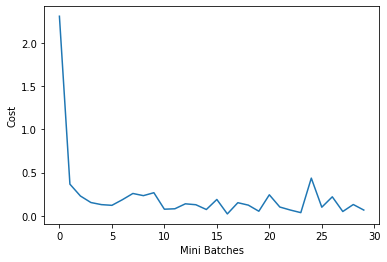

In [21]:
epochs = 5
learningRate = 0.01
model = NeuralNet(inputs,noOfNodesL1 , noOfNodesL2 , noOfNodesL3, outputs)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)   # Adding the Regularization Term

# Train the model
n_total_steps = batchSize
totalCost = []
for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for i, (images, labels) in enumerate(trainDataLoader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28)        
        # Forward pass
        yPred = model(images)
        loss = criterion(yPred, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i%100 == 0:
          print ("Cost after MiniBatch %i: %f" %(i, loss.item()))
          totalCost.append(loss.item())
plt.plot(totalCost)
plt.xlabel('Mini Batches')
plt.ylabel('Cost')
plt.show()

In [23]:
testAccuracy, confusionMatrixTest = predictPy(testData , model)
print('Test Accuracy = ' , float(testAccuracy)*100 , '%')
print('Confusion Matrix on Test Data: ')
print()
print(confusionMatrixTest)
print()

Test Accuracy =  97.4399983882904 %
Confusion Matrix on Test Data: 

[[ 966    0    0    0    0    1    9    1    0    3]
 [   1 1119    3    6    0    1    1    2    2    0]
 [   2    0  986    3    4    0    3   25    8    1]
 [   0    0    3  984    0    2    0    7    6    8]
 [   0    1    0    0  967    0    5    3    0    6]
 [   2    0    0   13    1  863    4    1    4    4]
 [   3    4    0    0    7    4  937    0    3    0]
 [   1    0    1    3    4    0    0 1010    2    7]
 [  13    0    3   11    6    5    0    2  930    4]
 [   1    2    0    4    6    3    1    7    3  982]]



# Additional Works

# Learning Rate vs Accuracy

Learning Rate =  1



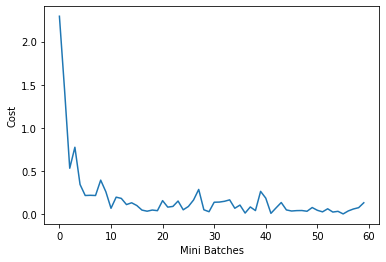

For Learning Rate = 1 Test Accuracy = 97.39
Learning Rate =  0.1



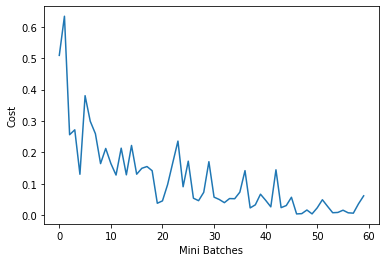

For Learning Rate = 0.1 Test Accuracy = 97.71
Learning Rate =  0.01



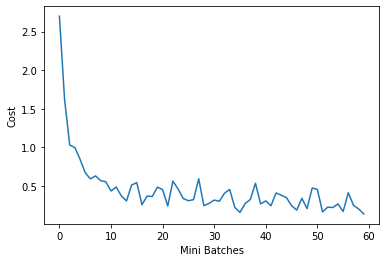

For Learning Rate = 0.01 Test Accuracy = 95.43
Learning Rate =  0.001



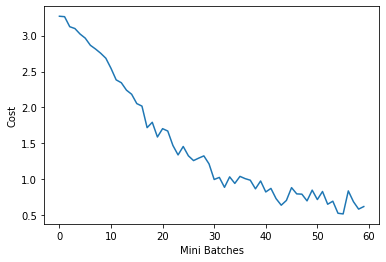

For Learning Rate = 0.001 Test Accuracy = 88.64
Learning Rate =  0.0001



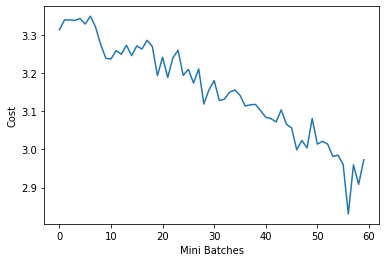

For Learning Rate = 0.0001 Test Accuracy = 44.98


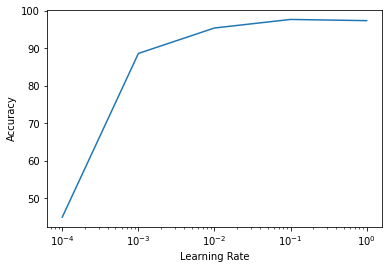

In [ ]:
"""
Number Of Epochs - 10 (Fixed)
BatchSize - 100 (Fixed)
No Regularization
Network Architecture - same as baseline

"""

accuracy = []
for i in range(5):
  learningRate = 10**(-i)
  print('Learning Rate = ' , learningRate)
  w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 = initializingParameters()
  w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 , trainData , testData = Model('reLu' , learningRate , False , epochs , False)
  testAccuracy, confusionMatrixTest = predict(testData, w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 ,'reLu')
  print('For Learning Rate =', learningRate , 'Test Accuracy =',testAccuracy*100)
  accuracy.append(testAccuracy*100)
plt.xscale("log")
plt.plot([10**(-i) for i in range(5)] , accuracy)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.show()


**Learning Rate of 0.1 seems to have the accuracy, given other Hyper- Parameters for first model**

# Experimenting on the Decay Rate

For Alpha =  1 Accuracy = 10.279999732971191


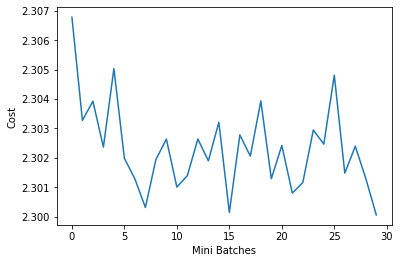

For Alpha =  0.1 Accuracy = 11.350000381469727


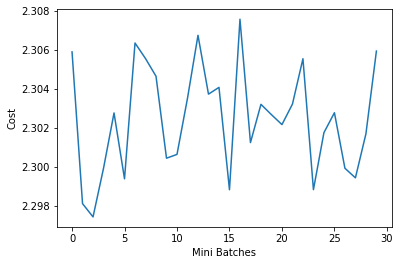

For Alpha =  0.01 Accuracy = 91.88999938964844


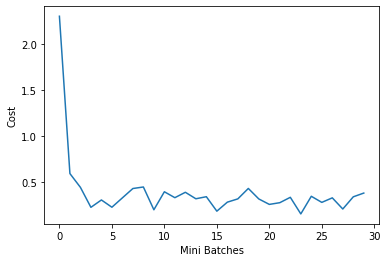

For Alpha =  0.001 Accuracy = 95.36000061035156


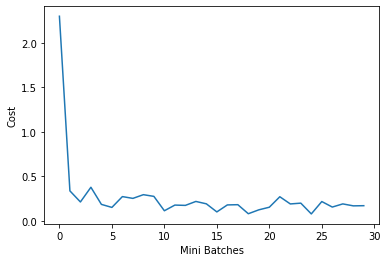

For Alpha =  0.0001 Accuracy = 96.25


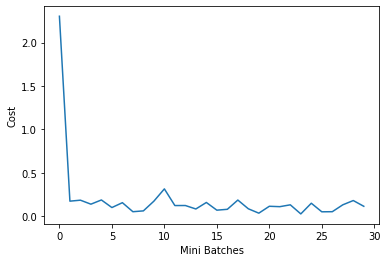

For Alpha =  1e-05 Accuracy = 96.77000427246094


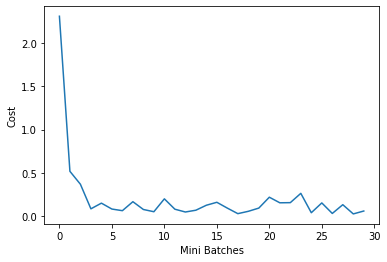

For Alpha =  1e-06 Accuracy = 96.6500015258789


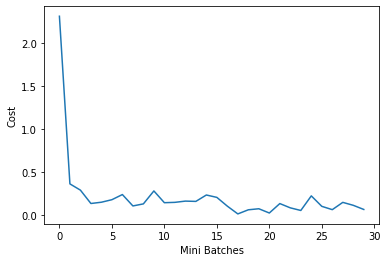

For Alpha =  1e-07 Accuracy = 96.6300048828125


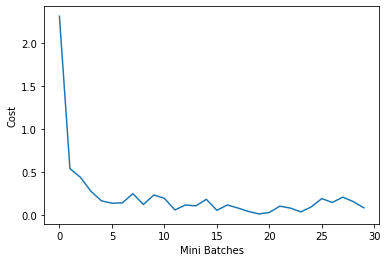

For Alpha =  1e-08 Accuracy = 96.4800033569336


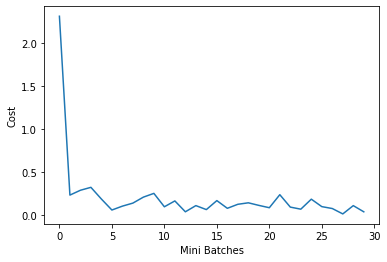

For Alpha =  1e-09 Accuracy = 96.97999572753906


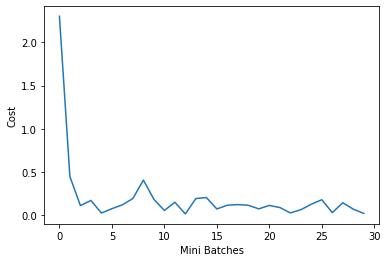

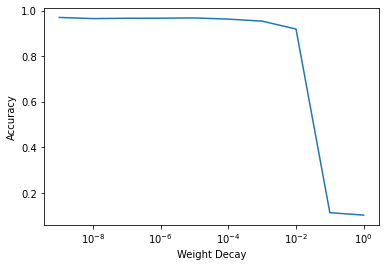

In [27]:
epochs = 5
batchSize = 100 
learningRate = 0.01 

accuracy = []
for j in range(0 , 10):
    alpha = 10**(-j)
    model = NeuralNet(inputs,noOfNodesL1 , noOfNodesL2 , noOfNodesL3, outputs)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate , weight_decay = alpha)   # Adding the Regularization Term

    # Train the model
    n_total_steps = batchSize
    totalCost = []
    for epoch in range(epochs):
        #print('Epoch {}'.format(epoch))
        for i, (images, labels) in enumerate(trainDataLoader):  
            # origin shape: [100, 1, 28, 28]
            # resized: [100, 784]
            images = images.reshape(-1, 28*28)        
            # Forward pass
            yPred = model(images)
            loss = criterion(yPred, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i%100 == 0:
                #print ("Cost after MiniBatch %i: %f" %(i, loss.item()))
                totalCost.append(loss.item())
    testAccuracy, confusionMatrixTest = predictPy(testData , model)
    print('For Alpha = ' , alpha , 'Accuracy =' , float(testAccuracy*100))
    plt.plot(totalCost)
    plt.xlabel('Mini Batches')
    plt.ylabel('Cost')
    plt.show()

    accuracy.append(testAccuracy)
plt.xscale("log")
plt.plot([10**(-i) for i in range(10)] , accuracy)
plt.xlabel('Weight Decay')
plt.ylabel('Accuracy')
plt.show()


Any decay rate less than 1e-3 seems to give good Test Accuracy as seen from the plot. This possibly low value of weight decay implies that the architecture is at the right model complexity and that regularization might not be necessary

# BatchSize vs. Accuracy

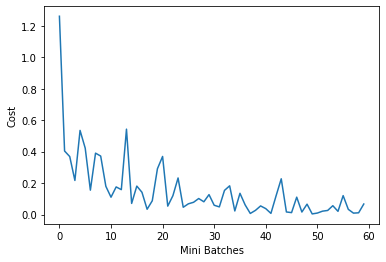

For BatchSize =  50 Accuracy =  98.04



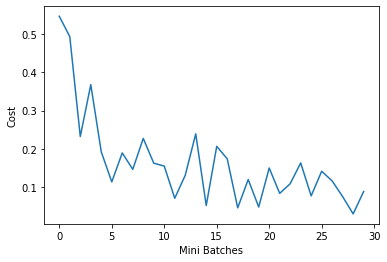

For BatchSize =  100 Accuracy =  97.67



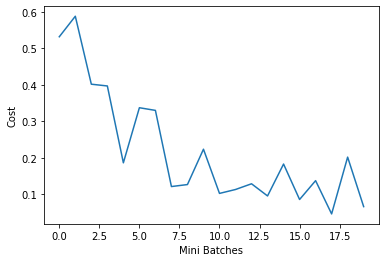

For BatchSize =  150 Accuracy =  97.09



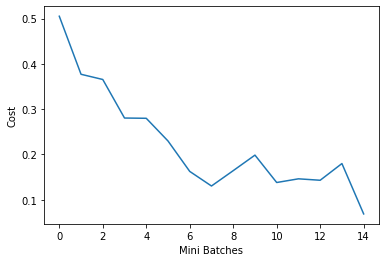

For BatchSize =  200 Accuracy =  97.15



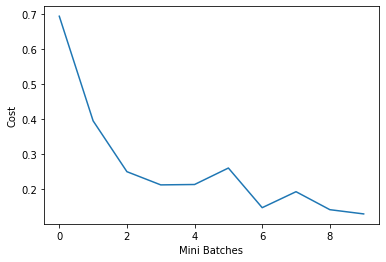

For BatchSize =  250 Accuracy =  96.78999999999999



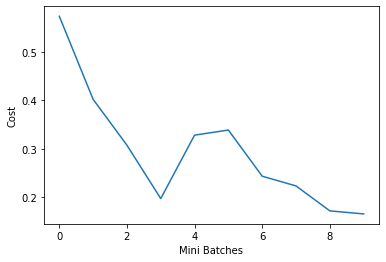

For BatchSize =  300 Accuracy =  96.37


In [38]:
accuracy = []
epochs = 5
learningRate = 0.1 # From Previous Plot
trainDataLoader , testData , trainData = loadDataSet()

for batchSize in range(50,301 , 50):
  trainDataLoader = DataLoader(trainData , batch_size = batchSize , shuffle = False)
  w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 = initializingParameters()
  w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 , trainData , testData = Model('reLu' , learningRate , False , epochs , False)
  testAccuracy, confusionMatrixTest = predict(testData, w1 , b1 , w2 , b2 , w3 , b3 , w4 , b4 , 'reLu')
  accuracy.append(testAccuracy*100)
  print('For BatchSize = ' ,batchSize , 'Accuracy = ' , float(testAccuracy*100))


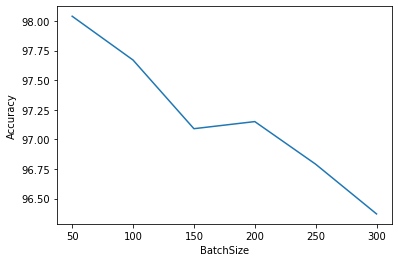

In [39]:
plt.plot(range(50,301 , 50) , accuracy)
plt.xlabel('BatchSize')
plt.ylabel('Accuracy')
plt.show()

There seems to be a decrease in the accuracy, as we increase the batchSize which seems logical. But computationally, it is pretty expensive for a small Batch Size. And the difference in accuracy is also not huge w.r.t small and large batchSize. 

# Number of Epochs vs Accuracy

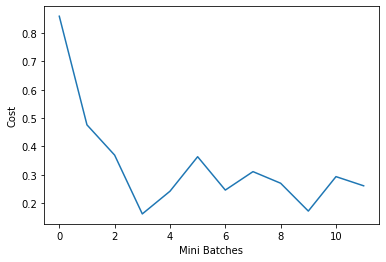

For No. Of Epochs =  1 Accuracy =  94.21000000000001


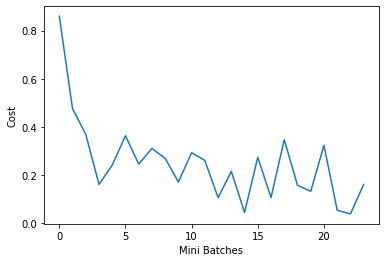

For No. Of Epochs =  2 Accuracy =  97.04


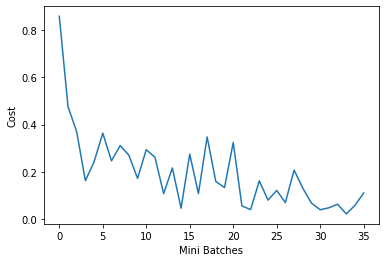

For No. Of Epochs =  3 Accuracy =  96.52


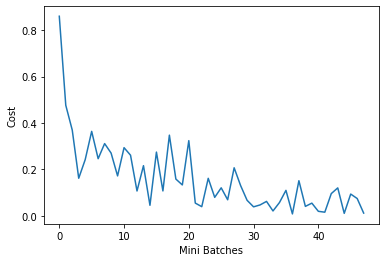

For No. Of Epochs =  4 Accuracy =  97.69


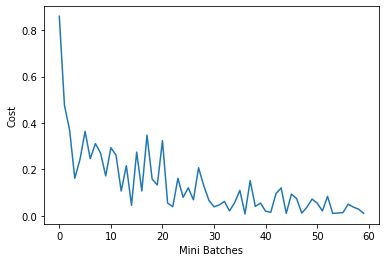

For No. Of Epochs =  5 Accuracy =  97.97


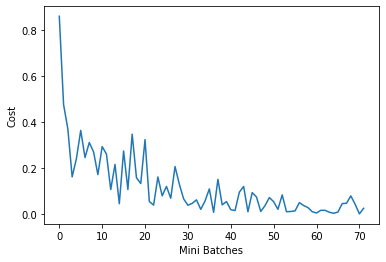

For No. Of Epochs =  6 Accuracy =  97.78


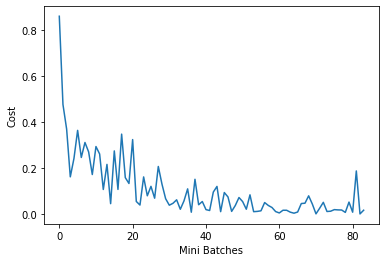

For No. Of Epochs =  7 Accuracy =  97.39


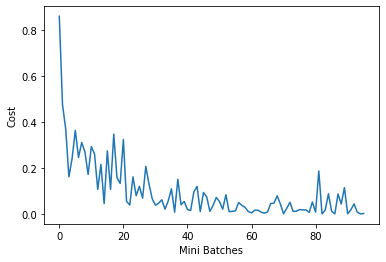

For No. Of Epochs =  8 Accuracy =  98.16


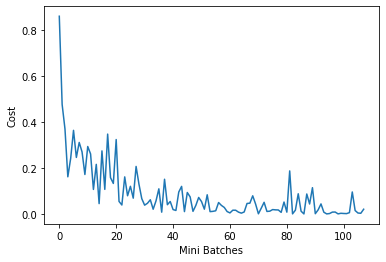

For No. Of Epochs =  9 Accuracy =  98.11


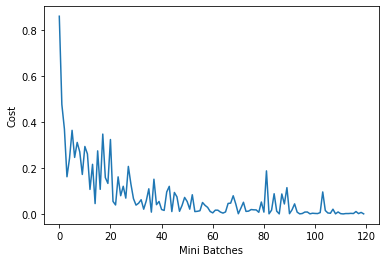

For No. Of Epochs =  10 Accuracy =  98.14


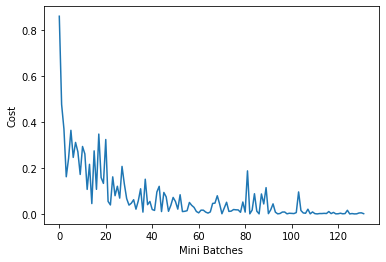

For No. Of Epochs =  11 Accuracy =  98.25


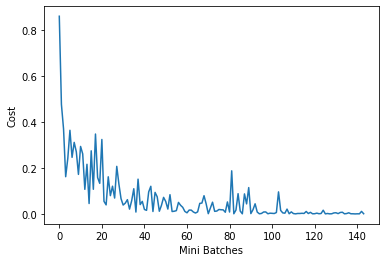

For No. Of Epochs =  12 Accuracy =  98.26


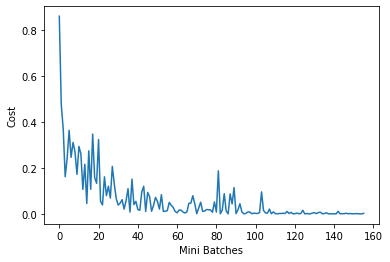

For No. Of Epochs =  13 Accuracy =  98.29


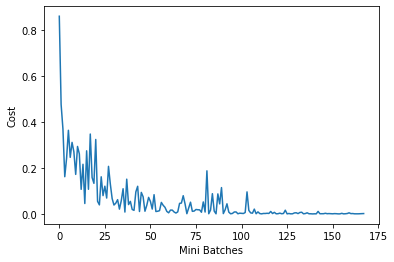

For No. Of Epochs =  14 Accuracy =  98.36


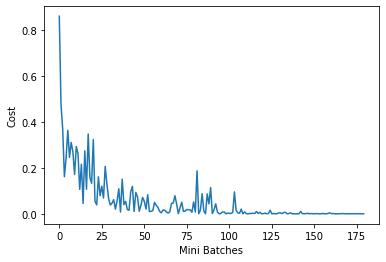

For No. Of Epochs =  15 Accuracy =  98.37


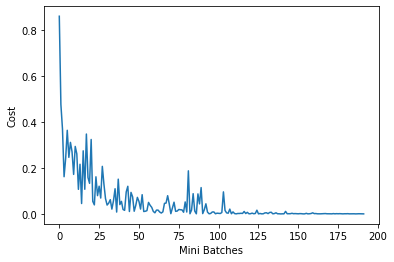

For No. Of Epochs =  16 Accuracy =  98.33


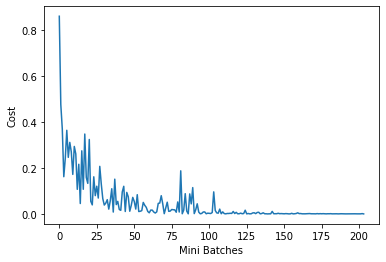

For No. Of Epochs =  17 Accuracy =  98.33


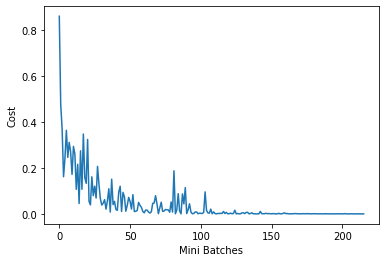

For No. Of Epochs =  18 Accuracy =  98.38


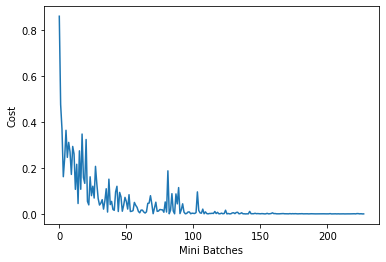

For No. Of Epochs =  19 Accuracy =  98.35000000000001


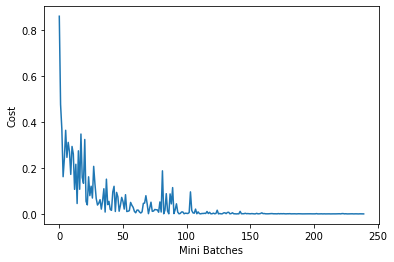

For No. Of Epochs =  20 Accuracy =  98.32



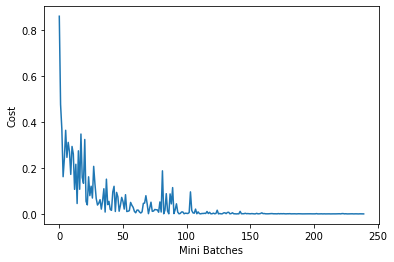

In [54]:
epochs = 20
# From Before
batchSize = 50
learningRate = 0.1
accuracy = []
w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 = initializingParameters()
w1 , b1 , w2, b2 , w3 , b3 , w4 , b4 , trainData , testData = Model('reLu' , learningRate , False , epochs , True)



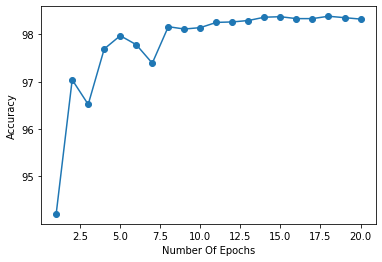

In [60]:
plt.plot(range(1,21) , accuracy , marker = 'o')
plt.xlabel('Number Of Epochs')
plt.ylabel('Accuracy')
plt.show()

Almost after 10 Epochs, there isn't any significant change in the accuracy. So computationally it is good if we just train the model for 10 Epochs

# Conclusion

Based on the above plots, we can fix the hyperparameters as follows, with a decent tradeoff between training time and accuracy, without changing the architecture

* learningRate - 0.1
* batchSize - 50
* Number of Epochs - 10
* Weight Decay (PyTorch Model)- 1e-6